# Predicting Causal SNPs

## Imports

In [1]:
# You can get rid of whatever libraries you dont need

import sys
import os
import random
import numpy as np
from numba import jit, prange
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_undirected, negative_sampling
import networkx as nx
from scipy.spatial import cKDTree
from scipy.special import expit
from typing import List, Dict
import time
import cProfile
import pstats
import io
import category_encoders as ce
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import copy
from torch_geometric.transforms import RandomNodeSplit
from collections import Counter



# Print versions of imported libraries
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Torch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda")          # Current CUDA device
    print(f"Using {torch.cuda.get_device_name()} ({device})")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Python version: 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
NumPy version: 1.24.1
Pandas version: 2.1.0
Matplotlib version: 3.7.2
Scikit-learn version: 1.3.0
Torch version: 2.0.1+cu117
Torch Geometric version: 2.3.1
NetworkX version: 3.0
Using NVIDIA RTX A6000 (cuda)
CUDA version: 11.7
Number of CUDA devices: 2


## All Chroms

In [2]:
%%time

import pandas as pd
import networkit as nk
from itertools import combinations
from collections import defaultdict

# Load and prepare the data
data = pd.read_parquet('gwas_fm_t2d.parquet')

# Get unique chromosome numbers
chromosomes = data['#chrom'].unique()

# Initialize an empty list to store results
results = []

for chrom in chromosomes:
    print(f"Processing chromosome {chrom}...")

    df = data[data['#chrom'] == chrom]
    df.reset_index(drop=True, inplace=True)

    # Create a graph and add nodes
    G = nk.Graph(directed=False)
    G.addNodes(len(df))

    # Store node attributes in a dictionary
    attributes = ['pos', 'ref', 'alt', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'prob', 'lead_r2', 'cs_99', 'causal']
    node_attributes = {attr: df[attr].tolist() for attr in attributes}

    # Get gene columns and create a mapping from gene values to node indices
    gene_cols = [f'gene_{i}' for i in range(22)]
    melted_df = df.reset_index().melt(id_vars='index', value_vars=gene_cols)
    grouped_df = melted_df[melted_df['value'].notnull() & (melted_df['value'] != 0)].groupby('value')['index'].apply(list)

    # Add edges to the graph based on genes
    added_edges = set()
    for node_indices in grouped_df:
        for i, j in combinations(node_indices, 2):
            if (i, j) not in added_edges and (j, i) not in added_edges:
                G.addEdge(i, j)
                added_edges.add((i, j))

    # Compute the number of connected components
    components = nk.components.ConnectedComponents(G)
    components.run()

    # Get the component of each node and identify causal nodes
    node_to_component = components.getPartition()
    causal_node_indices = [i for i, val in enumerate(node_attributes['causal']) if val == 1]

    # Identify and print details of components with causal nodes
    causal_node_components = {i: node_to_component[i] for i in causal_node_indices}

    component_sizes = components.getComponentSizes()
    unique_component_ids_and_sizes = {component: component_sizes[component] for component in set(causal_node_components.values())}

    # Check for edges between causal nodes in the same component
    components_to_causal_nodes = defaultdict(list)
    for node, component in causal_node_components.items():
        components_to_causal_nodes[component].append(node)

    # Create a dictionary to store results of the current chromosome
    chrom_results = {
        "chromosome": chrom,
        "total_nodes": G.numberOfNodes(),
        "total_edges": G.numberOfEdges(),
        "connected_components": components.numberOfComponents(),
        "causal_nodes_count": len(causal_node_indices),
        "causal_node_details": causal_node_components,
        "component_details": unique_component_ids_and_sizes,
        "edge_checks": []
    }
    
    for component, nodes in components_to_causal_nodes.items():
        for u, v in combinations(nodes, 2):
            has_edge = G.hasEdge(u, v)
            edge_check_details = {
                "component": component, 
                "node_pair": (u, v), 
                "has_edge": has_edge
            }
            chrom_results["edge_checks"].append(edge_check_details)

    # Add the current chromosome's results to the list
    results.append(chrom_results)

    print(f"Completed processing for chromosome {chrom}\n")

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file (or any other format you prefer)
results_df.to_csv('chromosome_results_t2d.csv', index=False)

print("Script execution completed.")


Processing chromosome 1...
Completed processing for chromosome 1

Processing chromosome 2...
Completed processing for chromosome 2

Processing chromosome 3...
Completed processing for chromosome 3

Processing chromosome 4...
Completed processing for chromosome 4

Processing chromosome 5...
Completed processing for chromosome 5

Processing chromosome 6...
Completed processing for chromosome 6

Processing chromosome 7...
Completed processing for chromosome 7

Processing chromosome 8...
Completed processing for chromosome 8

Processing chromosome 9...
Completed processing for chromosome 9

Processing chromosome 10...
Completed processing for chromosome 10

Processing chromosome 11...
Completed processing for chromosome 11

Processing chromosome 12...
Completed processing for chromosome 12

Processing chromosome 13...
Completed processing for chromosome 13

Processing chromosome 14...
Completed processing for chromosome 14

Processing chromosome 15...
Completed processing for chromosome 15

KeyboardInterrupt: 

## Chrom Figs

### Chrom 5

Processing chromosome 5...


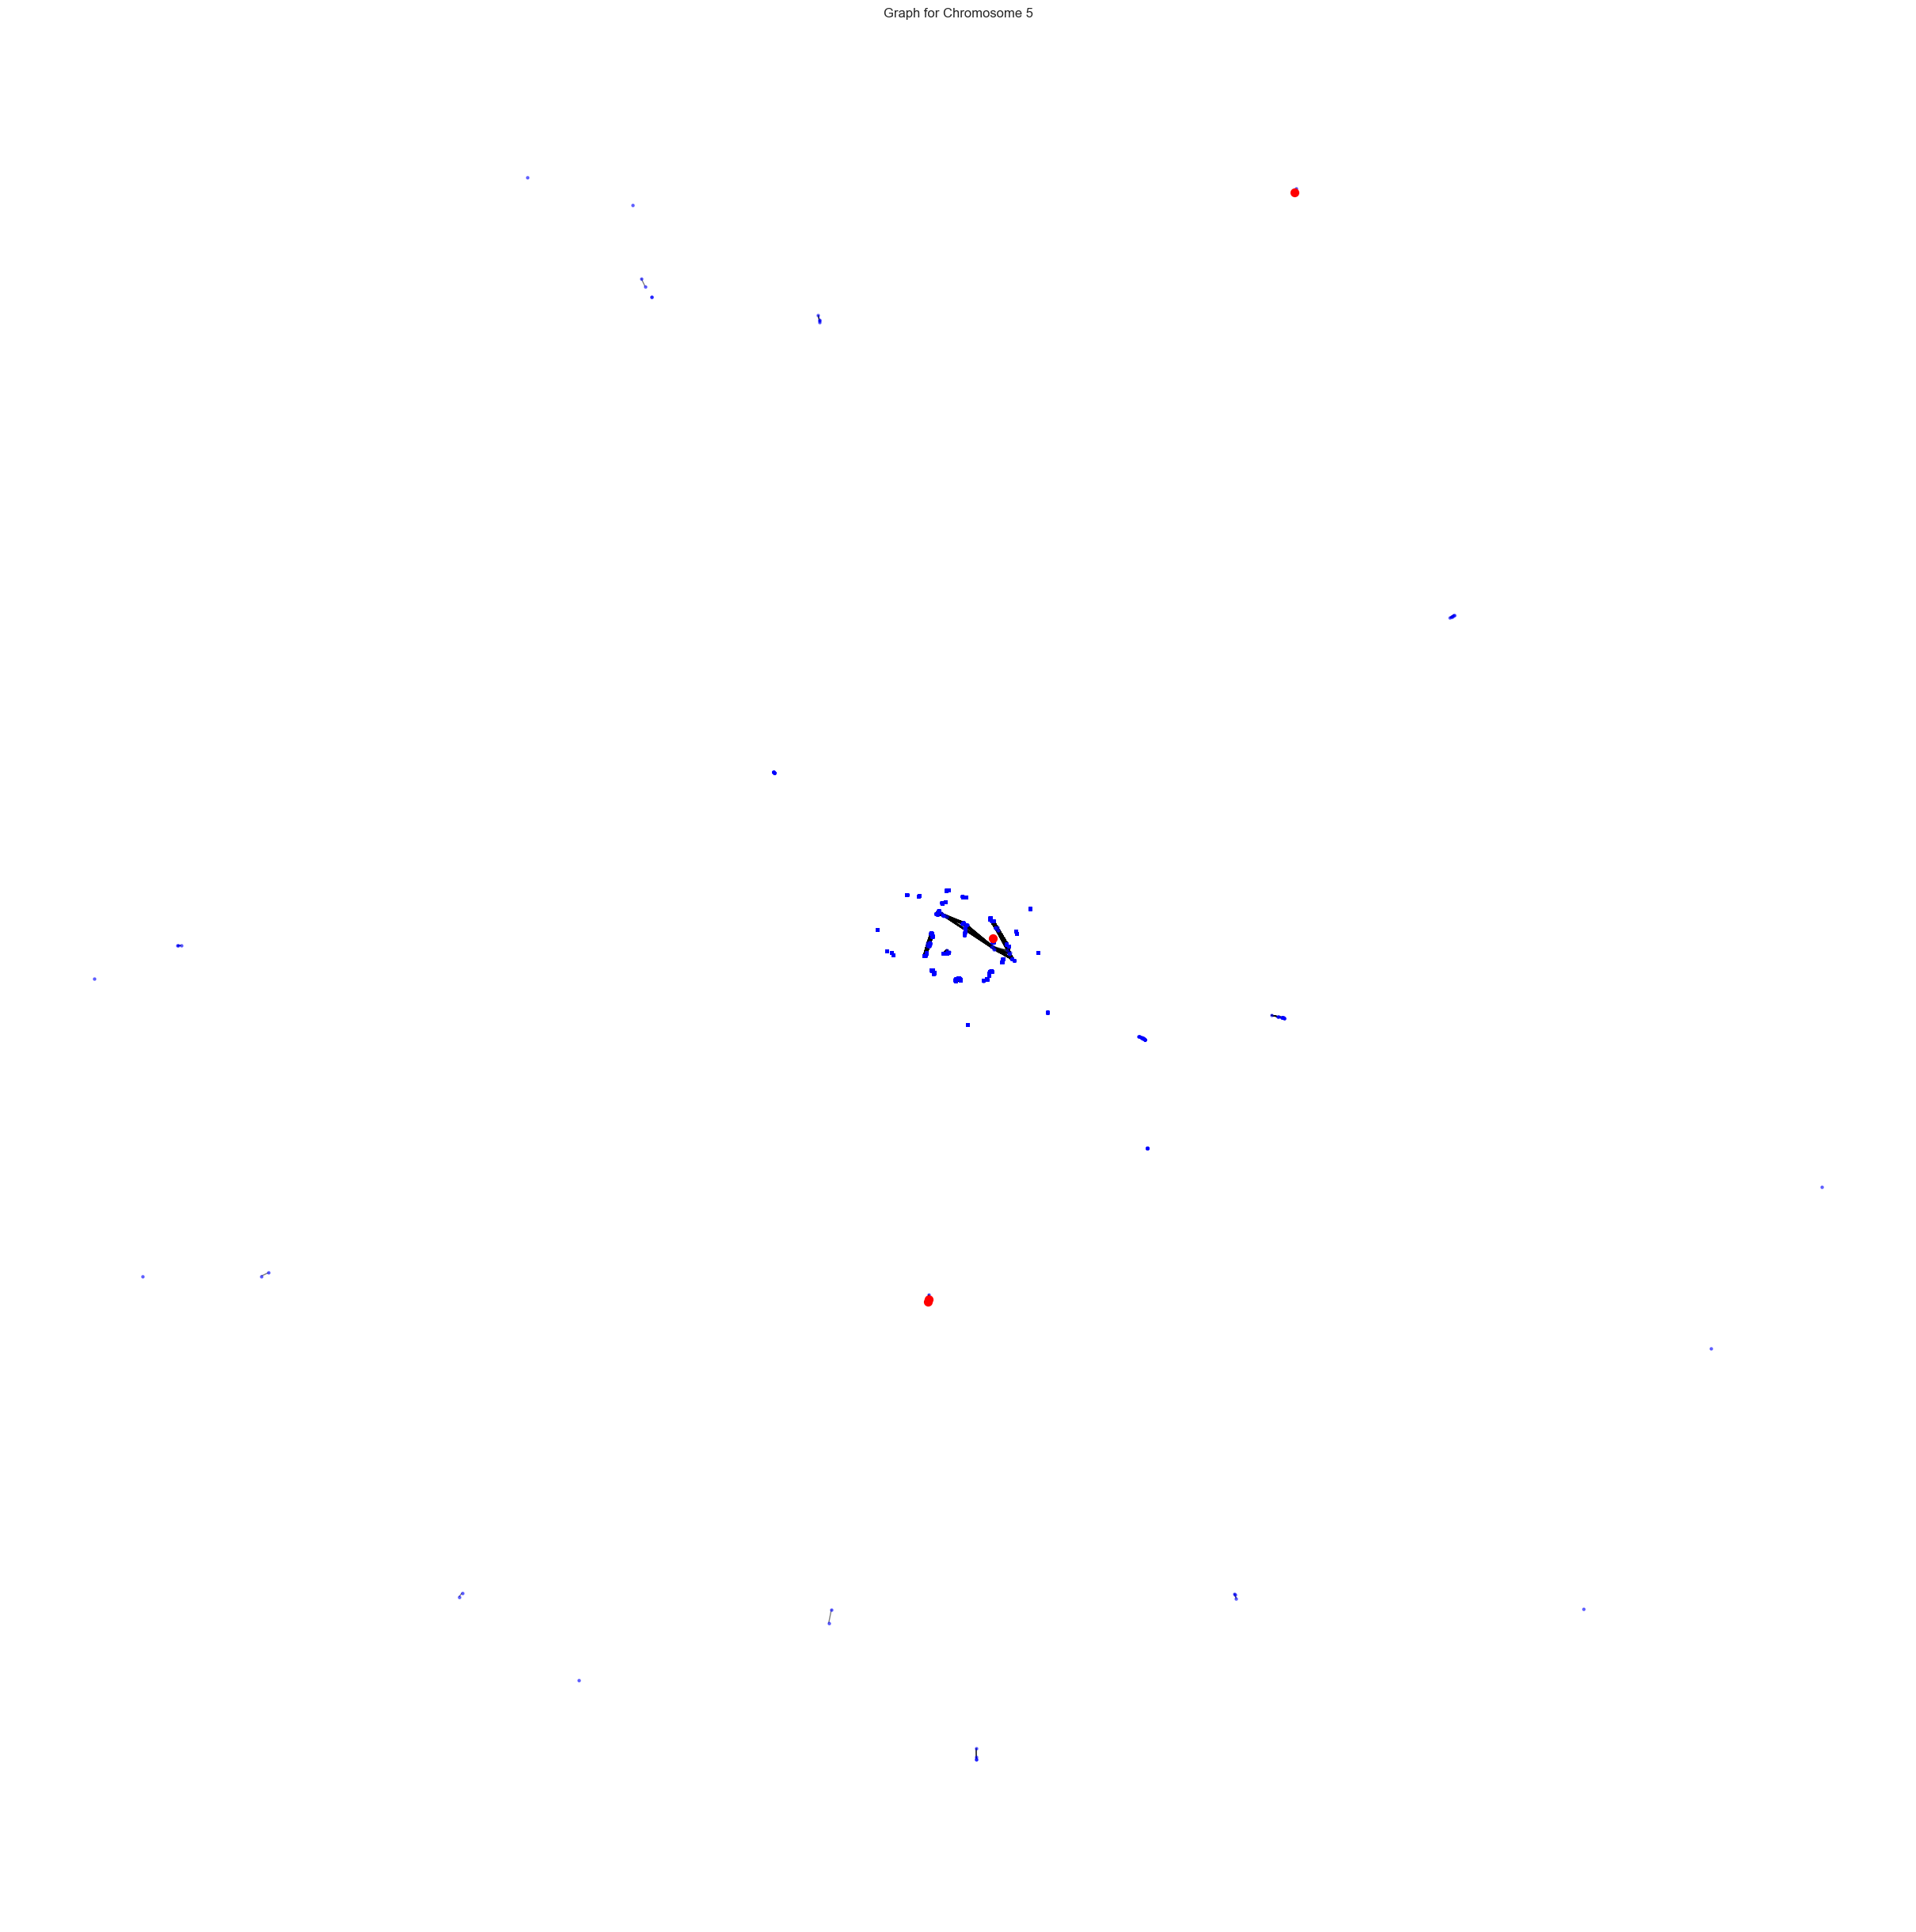

CPU times: total: 21min 8s
Wall time: 21min 20s


In [3]:
%%time

import pandas as pd
import networkit as nk
from itertools import combinations
from collections import defaultdict

# Load and prepare the data
data = pd.read_parquet('gwas_fm_t2d.parquet')

# Process only chromosome 5
chrom = 5

df = data[data['#chrom'] == chrom]
df.reset_index(drop=True, inplace=True)

# Initialize an empty list to store results
results = []

print(f"Processing chromosome {chrom}...")

# Create a graph and add nodes
G = nk.Graph(directed=False)
G.addNodes(len(df))

# Store node attributes in a dictionary
attributes = ['pos', 'ref', 'alt', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'prob', 'lead_r2', 'cs_99', 'causal']
node_attributes = {attr: df[attr].tolist() for attr in attributes}

# Get gene columns and create a mapping from gene values to node indices
gene_cols = [f'gene_{i}' for i in range(22)]
melted_df = df.reset_index().melt(id_vars='index', value_vars=gene_cols)
grouped_df = melted_df[melted_df['value'].notnull() & (melted_df['value'] != 0)].groupby('value')['index'].apply(list)

# Add edges to the graph based on genes
added_edges = set()
for node_indices in grouped_df:
    for i, j in combinations(node_indices, 2):
        if (i, j) not in added_edges and (j, i) not in added_edges:
            G.addEdge(i, j)
            added_edges.add((i, j))

# Compute the number of connected components
components = nk.components.ConnectedComponents(G)
components.run()

# Get the component of each node and identify causal nodes
node_to_component = components.getPartition()
causal_node_indices = [i for i, val in enumerate(node_attributes['causal']) if val == 1]

# Identify and print details of components with causal nodes
causal_node_components = {i: node_to_component[i] for i in causal_node_indices}

component_sizes = components.getComponentSizes()
unique_component_ids_and_sizes = {component: component_sizes[component] for component in set(causal_node_components.values())}

# Check for edges between causal nodes in the same component
components_to_causal_nodes = defaultdict(list)
for node, component in causal_node_components.items():
    components_to_causal_nodes[component].append(node)

# Create a dictionary to store results of the current chromosome
chrom_results = {
    "chromosome": chrom,
    "total_nodes": G.numberOfNodes(),
    "total_edges": G.numberOfEdges(),
    "connected_components": components.numberOfComponents(),
    "causal_nodes_count": len(causal_node_indices),
    "causal_node_details": causal_node_components,
    "component_details": unique_component_ids_and_sizes,
    "edge_checks": []
}

for component, nodes in components_to_causal_nodes.items():
    for u, v in combinations(nodes, 2):
        has_edge = G.hasEdge(u, v)
        edge_check_details = {
            "component": component, 
            "node_pair": (u, v), 
            "has_edge": has_edge
        }
        chrom_results["edge_checks"].append(edge_check_details)

# Add the current chromosome's results to the list
results.append(chrom_results)

# Convert the networkit graph to a networkx graph for visualization
G_nx = nk.nxadapter.nk2nx(G)

import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(24, 24))

# Using spring_layout for faster rendering; adjust as per need.
pos = nx.spring_layout(G_nx, iterations=50)  

# Extract nodes with causal=1
causal_nodes = [index for index, is_causal in enumerate(node_attributes['causal']) if is_causal == 1]

# Draw all nodes
nx.draw(G_nx, pos, node_size=5, node_color="blue", alpha=0.5, with_labels=False)

# Draw only causal=1 nodes on top with bright red color and larger size
nx.draw_networkx_nodes(G_nx, pos, nodelist=causal_nodes, node_color="red", node_size=50, alpha=1)

plt.title("Graph for Chromosome 5")
plt.show()


### Chrom 3

Processing chromosome 3...


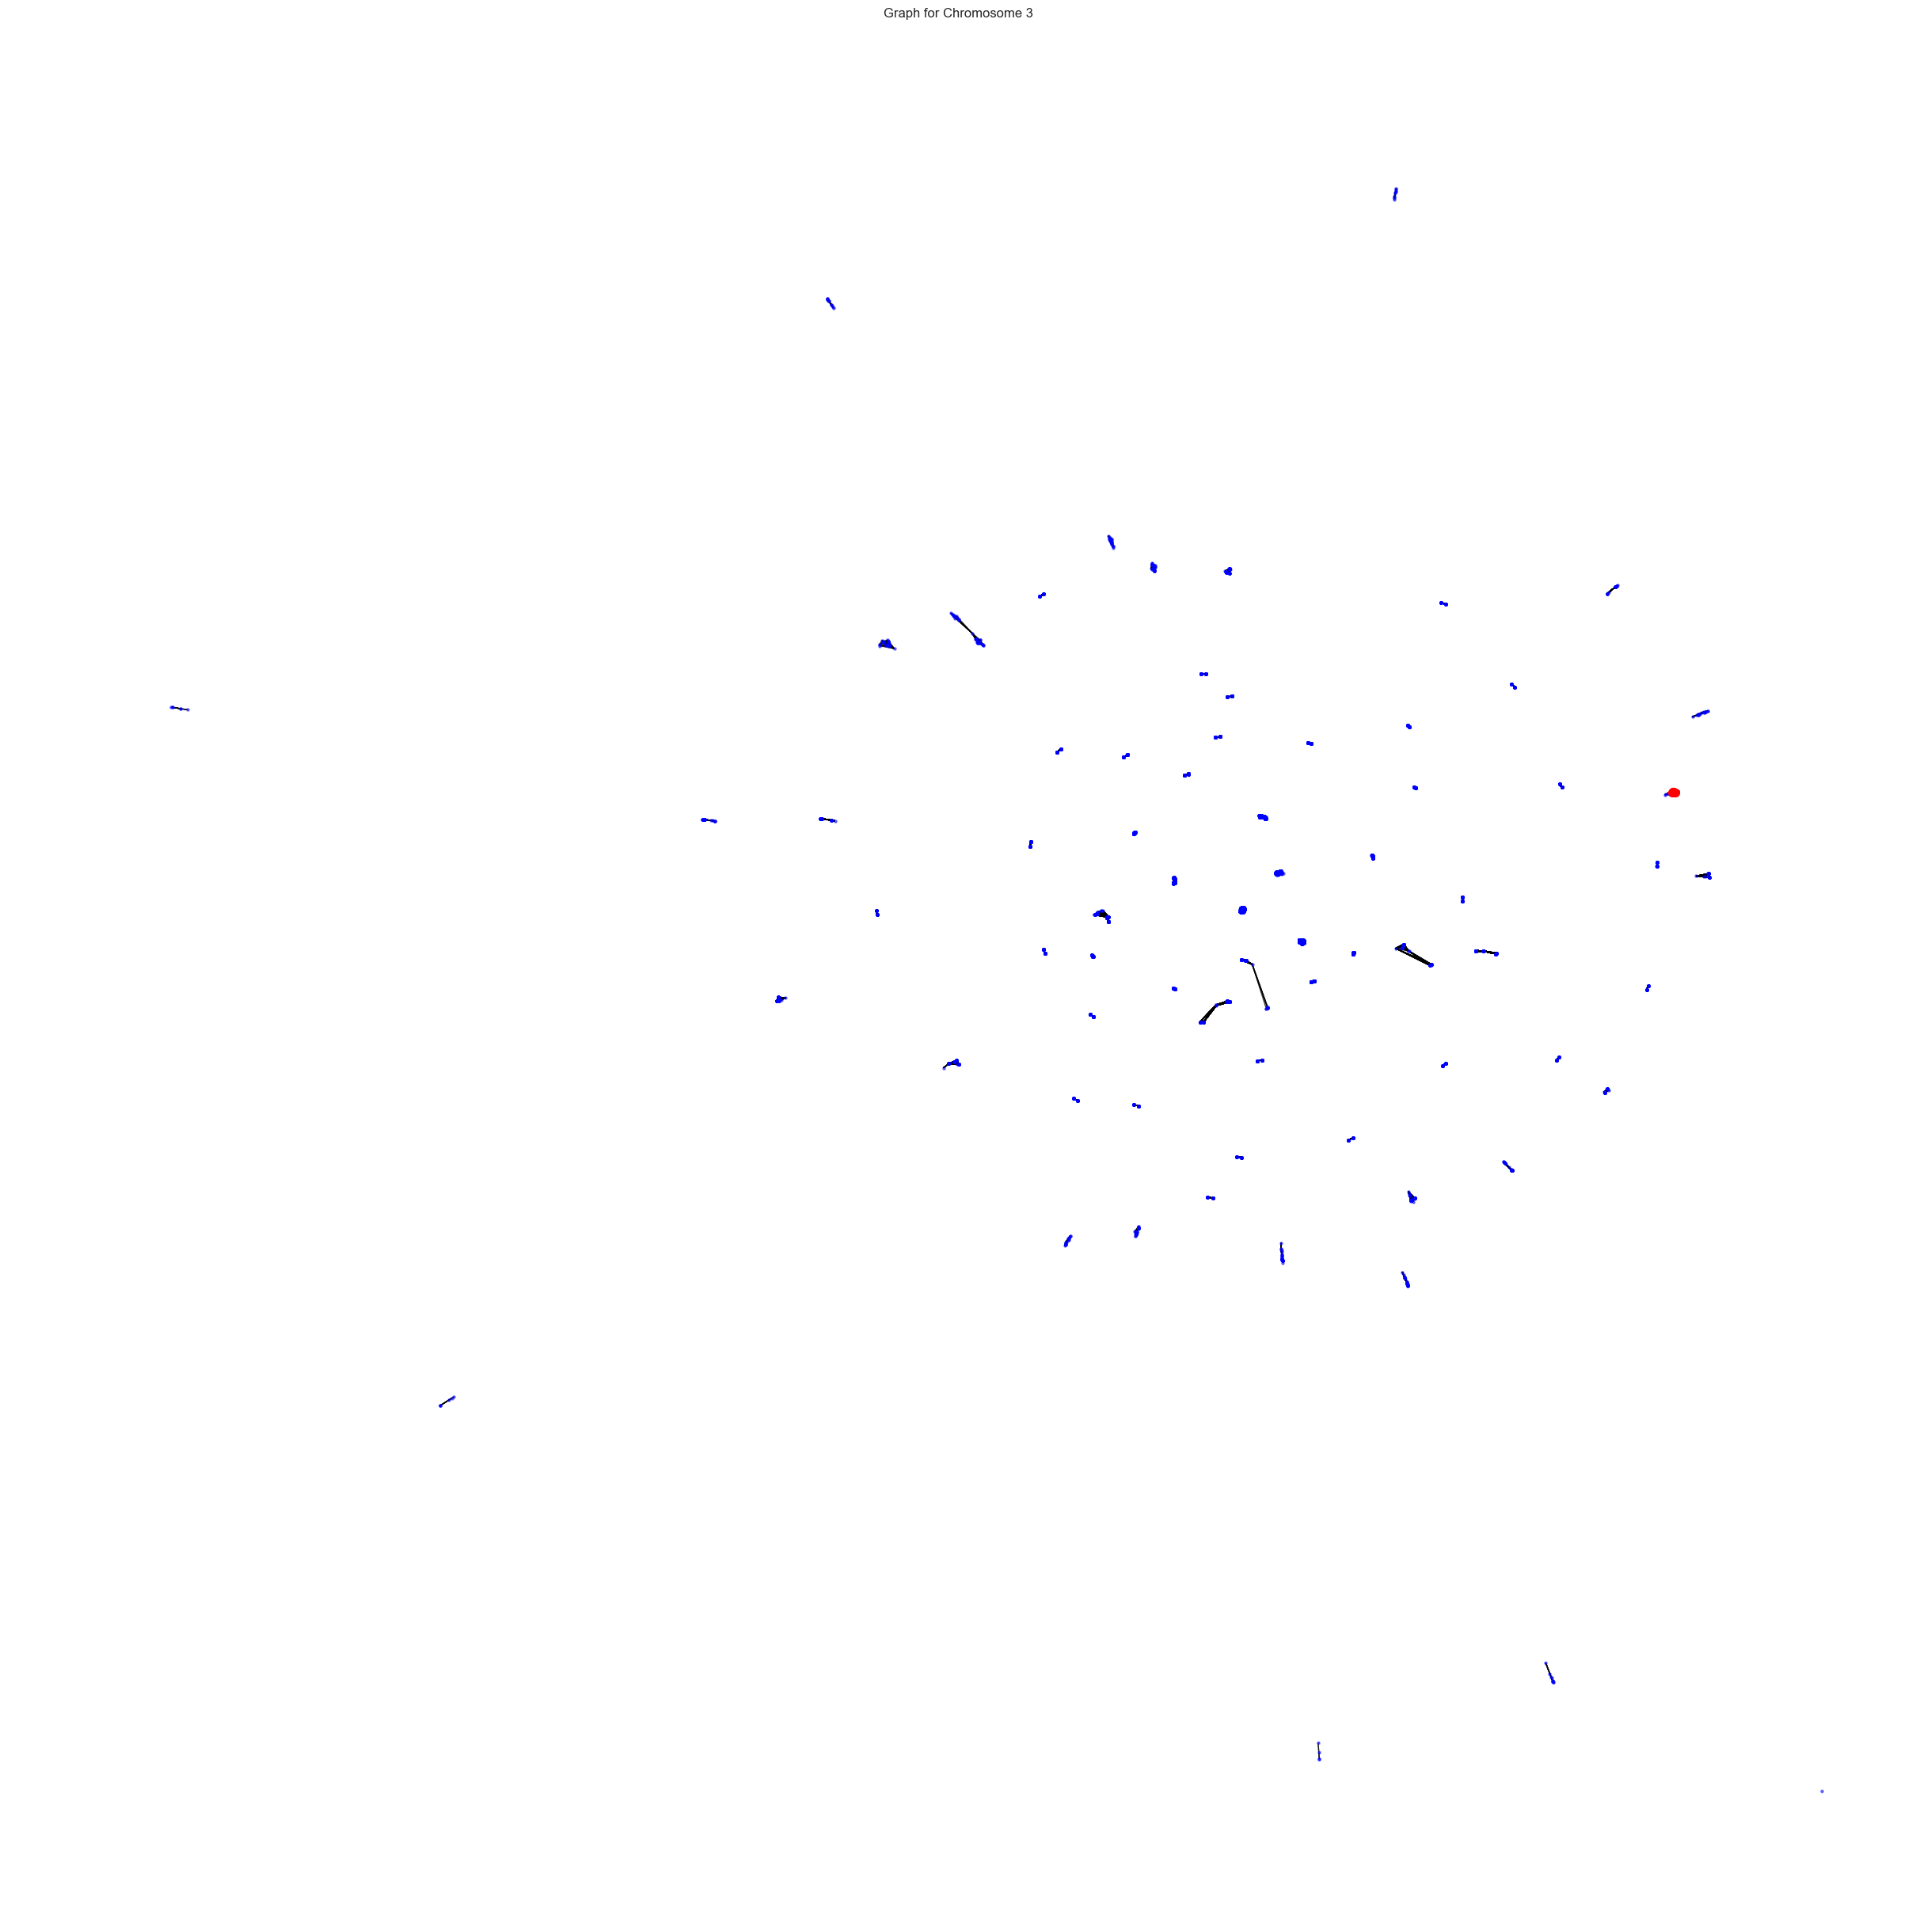

CPU times: total: 2min 48s
Wall time: 2min 50s


In [4]:
%%time

import pandas as pd
import networkit as nk
from itertools import combinations
from collections import defaultdict

# Load and prepare the data
data = pd.read_parquet('gwas_fm_t2d.parquet')

# Process only chromosome 3
chrom = 3

df = data[data['#chrom'] == chrom]
df.reset_index(drop=True, inplace=True)

# Initialize an empty list to store results
results = []

print(f"Processing chromosome {chrom}...")

# Create a graph and add nodes
G = nk.Graph(directed=False)
G.addNodes(len(df))

# Store node attributes in a dictionary
attributes = ['pos', 'ref', 'alt', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'prob', 'lead_r2', 'cs_99', 'causal']
node_attributes = {attr: df[attr].tolist() for attr in attributes}

# Get gene columns and create a mapping from gene values to node indices
gene_cols = [f'gene_{i}' for i in range(22)]
melted_df = df.reset_index().melt(id_vars='index', value_vars=gene_cols)
grouped_df = melted_df[melted_df['value'].notnull() & (melted_df['value'] != 0)].groupby('value')['index'].apply(list)

# Add edges to the graph based on genes
added_edges = set()
for node_indices in grouped_df:
    for i, j in combinations(node_indices, 2):
        if (i, j) not in added_edges and (j, i) not in added_edges:
            G.addEdge(i, j)
            added_edges.add((i, j))

# Compute the number of connected components
components = nk.components.ConnectedComponents(G)
components.run()

# Get the component of each node and identify causal nodes
node_to_component = components.getPartition()
causal_node_indices = [i for i, val in enumerate(node_attributes['causal']) if val == 1]

# Identify and print details of components with causal nodes
causal_node_components = {i: node_to_component[i] for i in causal_node_indices}

component_sizes = components.getComponentSizes()
unique_component_ids_and_sizes = {component: component_sizes[component] for component in set(causal_node_components.values())}

# Check for edges between causal nodes in the same component
components_to_causal_nodes = defaultdict(list)
for node, component in causal_node_components.items():
    components_to_causal_nodes[component].append(node)

# Create a dictionary to store results of the current chromosome
chrom_results = {
    "chromosome": chrom,
    "total_nodes": G.numberOfNodes(),
    "total_edges": G.numberOfEdges(),
    "connected_components": components.numberOfComponents(),
    "causal_nodes_count": len(causal_node_indices),
    "causal_node_details": causal_node_components,
    "component_details": unique_component_ids_and_sizes,
    "edge_checks": []
}

for component, nodes in components_to_causal_nodes.items():
    for u, v in combinations(nodes, 2):
        has_edge = G.hasEdge(u, v)
        edge_check_details = {
            "component": component, 
            "node_pair": (u, v), 
            "has_edge": has_edge
        }
        chrom_results["edge_checks"].append(edge_check_details)

# Add the current chromosome's results to the list
results.append(chrom_results)

# Convert the networkit graph to a networkx graph for visualization
G_nx = nk.nxadapter.nk2nx(G)

import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(24, 24))

# Using spring_layout for faster rendering; adjust as per need.
pos = nx.spring_layout(G_nx, iterations=50)  

# Extract nodes with causal=1
causal_nodes = [index for index, is_causal in enumerate(node_attributes['causal']) if is_causal == 1]

# Draw all nodes
nx.draw(G_nx, pos, node_size=5, node_color="blue", alpha=0.5, with_labels=False)

# Draw only causal=1 nodes on top with bright red color and larger size
nx.draw_networkx_nodes(G_nx, pos, nodelist=causal_nodes, node_color="red", node_size=50, alpha=1)

plt.title("Graph for Chromosome 3")
plt.show()


### Chrom 7

Processing chromosome 7...


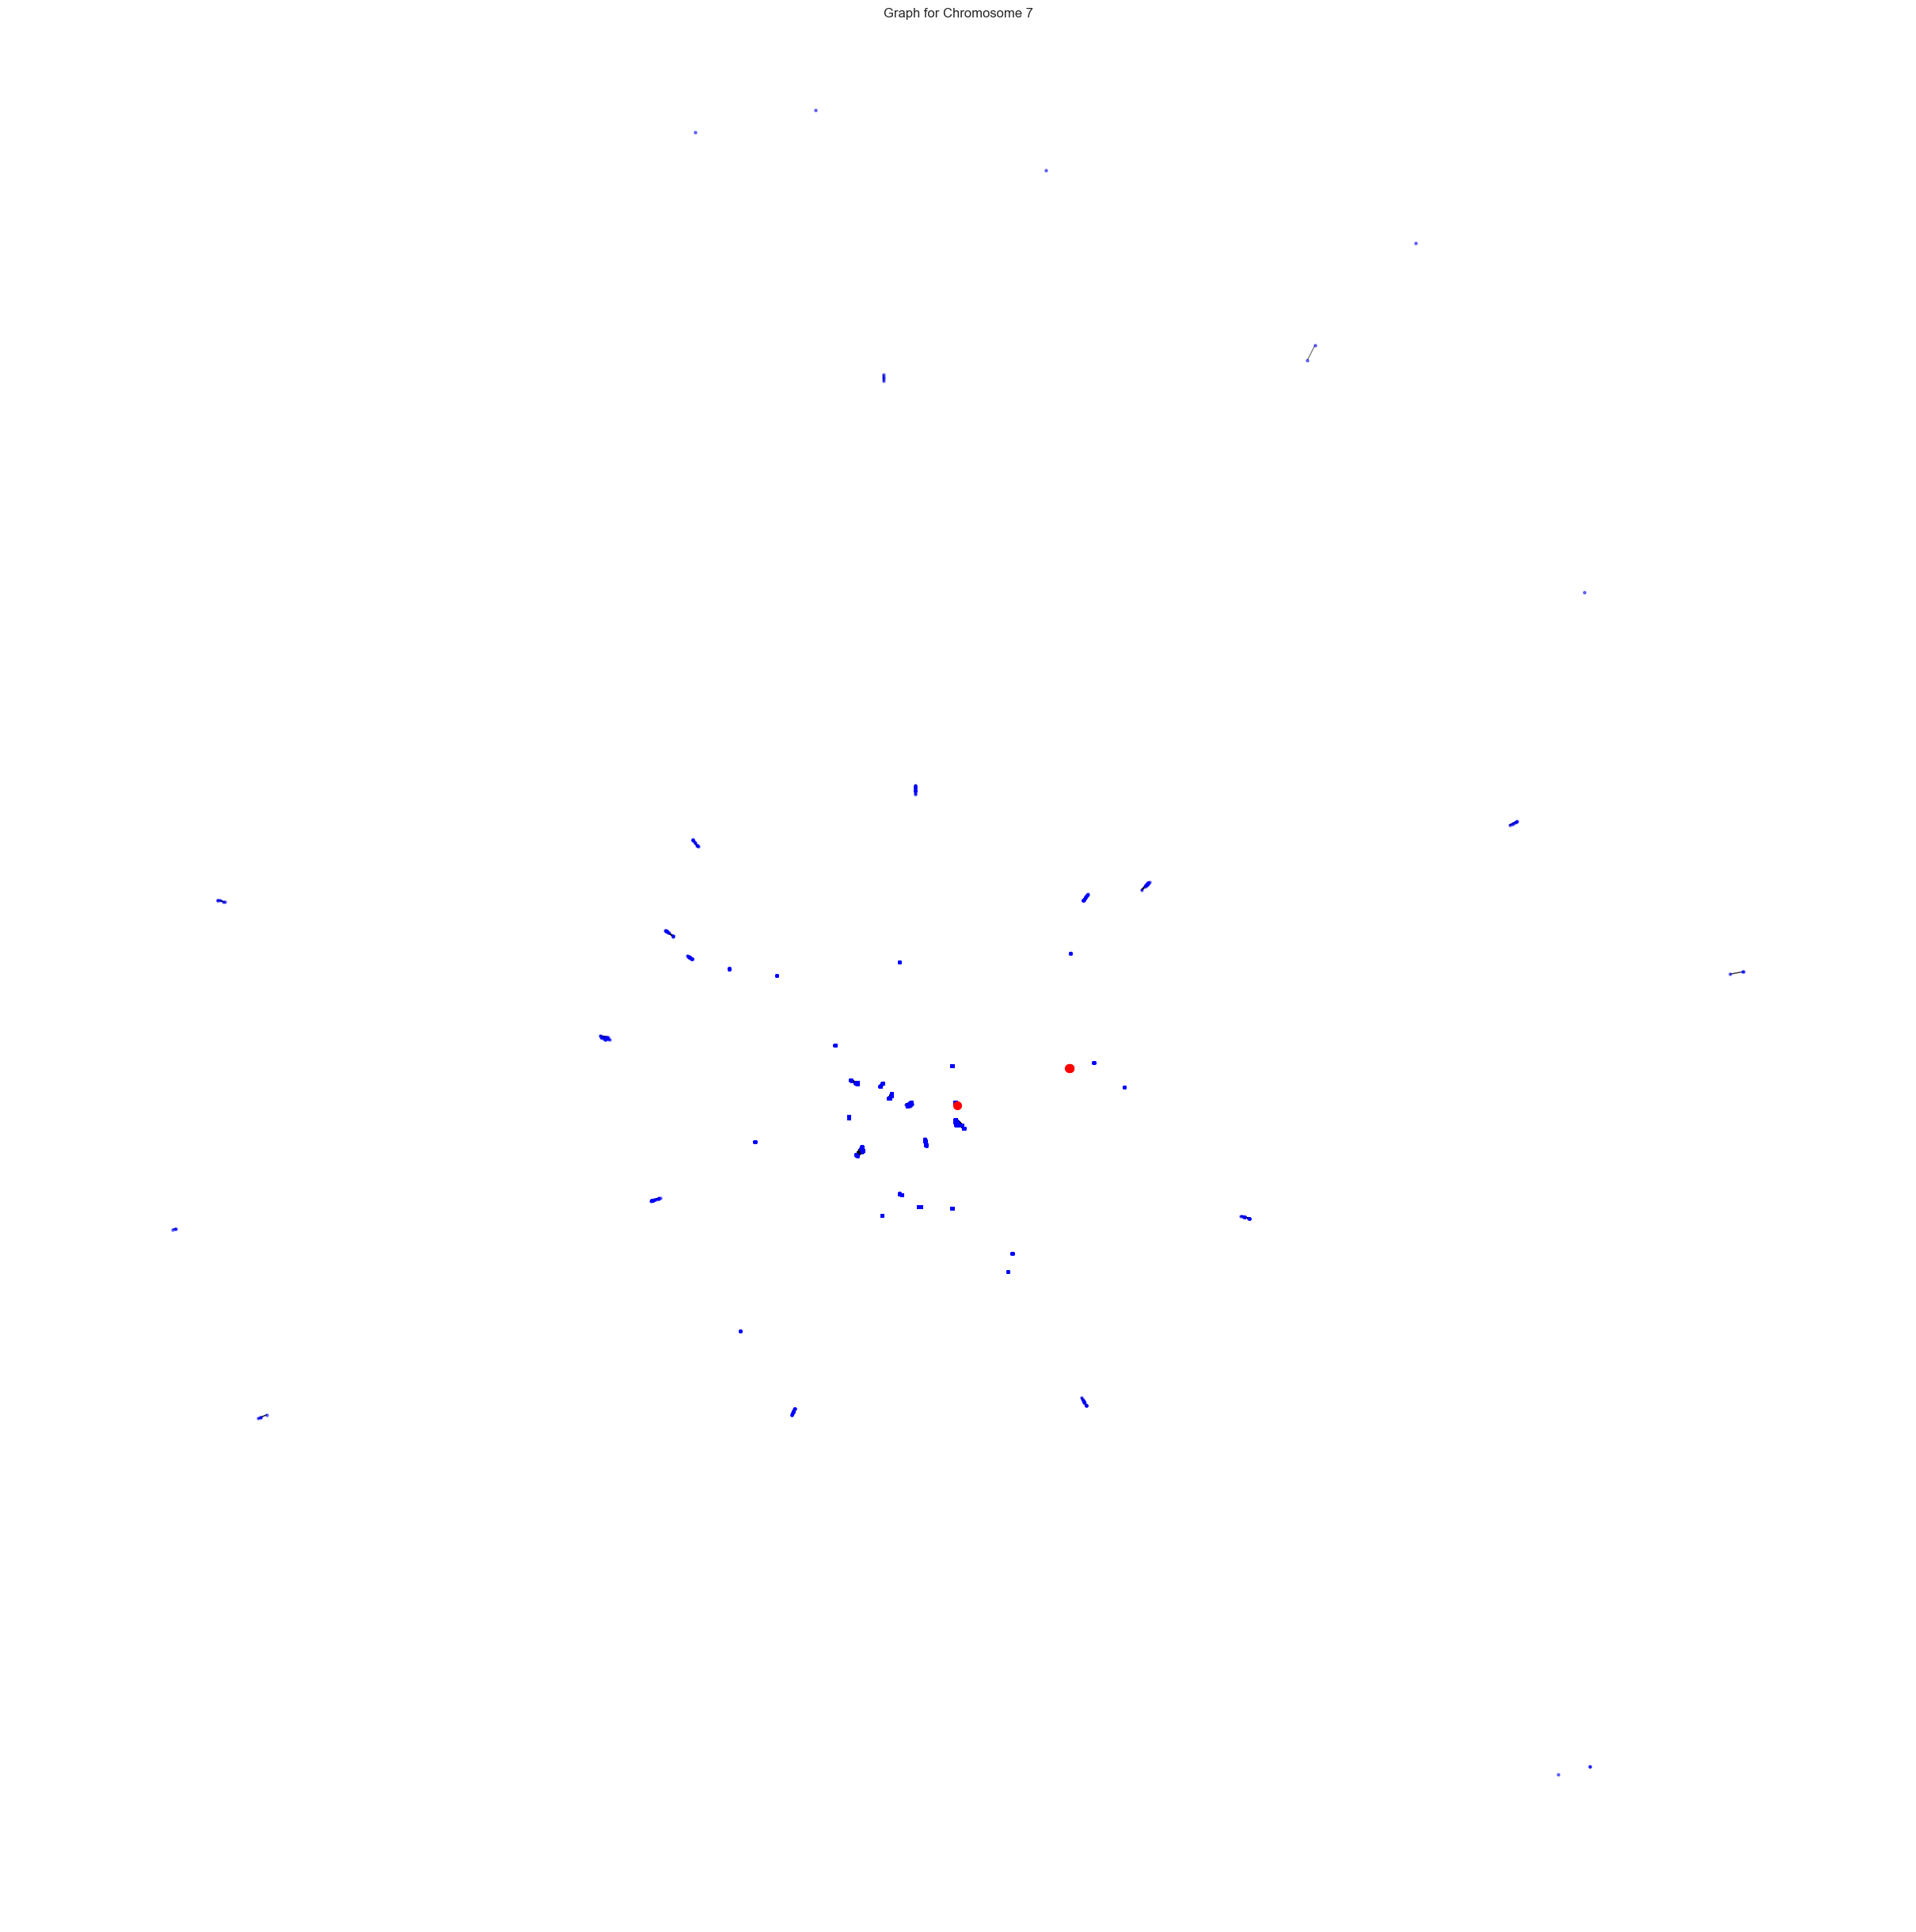

CPU times: total: 18min 31s
Wall time: 18min 45s


In [5]:
%%time

import pandas as pd
import networkit as nk
from itertools import combinations
from collections import defaultdict

# Load and prepare the data
data = pd.read_parquet('gwas_fm_t2d.parquet')

# Process only chromosome 7
chrom = 7

df = data[data['#chrom'] == chrom]
df.reset_index(drop=True, inplace=True)

# Initialize an empty list to store results
results = []

print(f"Processing chromosome {chrom}...")

# Create a graph and add nodes
G = nk.Graph(directed=False)
G.addNodes(len(df))

# Store node attributes in a dictionary
attributes = ['pos', 'ref', 'alt', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'prob', 'lead_r2', 'cs_99', 'causal']
node_attributes = {attr: df[attr].tolist() for attr in attributes}

# Get gene columns and create a mapping from gene values to node indices
gene_cols = [f'gene_{i}' for i in range(22)]
melted_df = df.reset_index().melt(id_vars='index', value_vars=gene_cols)
grouped_df = melted_df[melted_df['value'].notnull() & (melted_df['value'] != 0)].groupby('value')['index'].apply(list)

# Add edges to the graph based on genes
added_edges = set()
for node_indices in grouped_df:
    for i, j in combinations(node_indices, 2):
        if (i, j) not in added_edges and (j, i) not in added_edges:
            G.addEdge(i, j)
            added_edges.add((i, j))

# Compute the number of connected components
components = nk.components.ConnectedComponents(G)
components.run()

# Get the component of each node and identify causal nodes
node_to_component = components.getPartition()
causal_node_indices = [i for i, val in enumerate(node_attributes['causal']) if val == 1]

# Identify and print details of components with causal nodes
causal_node_components = {i: node_to_component[i] for i in causal_node_indices}

component_sizes = components.getComponentSizes()
unique_component_ids_and_sizes = {component: component_sizes[component] for component in set(causal_node_components.values())}

# Check for edges between causal nodes in the same component
components_to_causal_nodes = defaultdict(list)
for node, component in causal_node_components.items():
    components_to_causal_nodes[component].append(node)

# Create a dictionary to store results of the current chromosome
chrom_results = {
    "chromosome": chrom,
    "total_nodes": G.numberOfNodes(),
    "total_edges": G.numberOfEdges(),
    "connected_components": components.numberOfComponents(),
    "causal_nodes_count": len(causal_node_indices),
    "causal_node_details": causal_node_components,
    "component_details": unique_component_ids_and_sizes,
    "edge_checks": []
}

for component, nodes in components_to_causal_nodes.items():
    for u, v in combinations(nodes, 2):
        has_edge = G.hasEdge(u, v)
        edge_check_details = {
            "component": component, 
            "node_pair": (u, v), 
            "has_edge": has_edge
        }
        chrom_results["edge_checks"].append(edge_check_details)

# Add the current chromosome's results to the list
results.append(chrom_results)

# Convert the networkit graph to a networkx graph for visualization
G_nx = nk.nxadapter.nk2nx(G)

import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(24, 24))

# Using spring_layout for faster rendering; adjust as per need.
pos = nx.spring_layout(G_nx, iterations=50)  

# Extract nodes with causal=1
causal_nodes = [index for index, is_causal in enumerate(node_attributes['causal']) if is_causal == 1]

# Draw all nodes
nx.draw(G_nx, pos, node_size=5, node_color="blue", alpha=0.5, with_labels=False)

# Draw only causal=1 nodes on top with bright red color and larger size
nx.draw_networkx_nodes(G_nx, pos, nodelist=causal_nodes, node_color="red", node_size=50, alpha=1)

plt.title("Graph for Chromosome 7")
plt.show()


### Chrom 10

Processing chromosome 10...


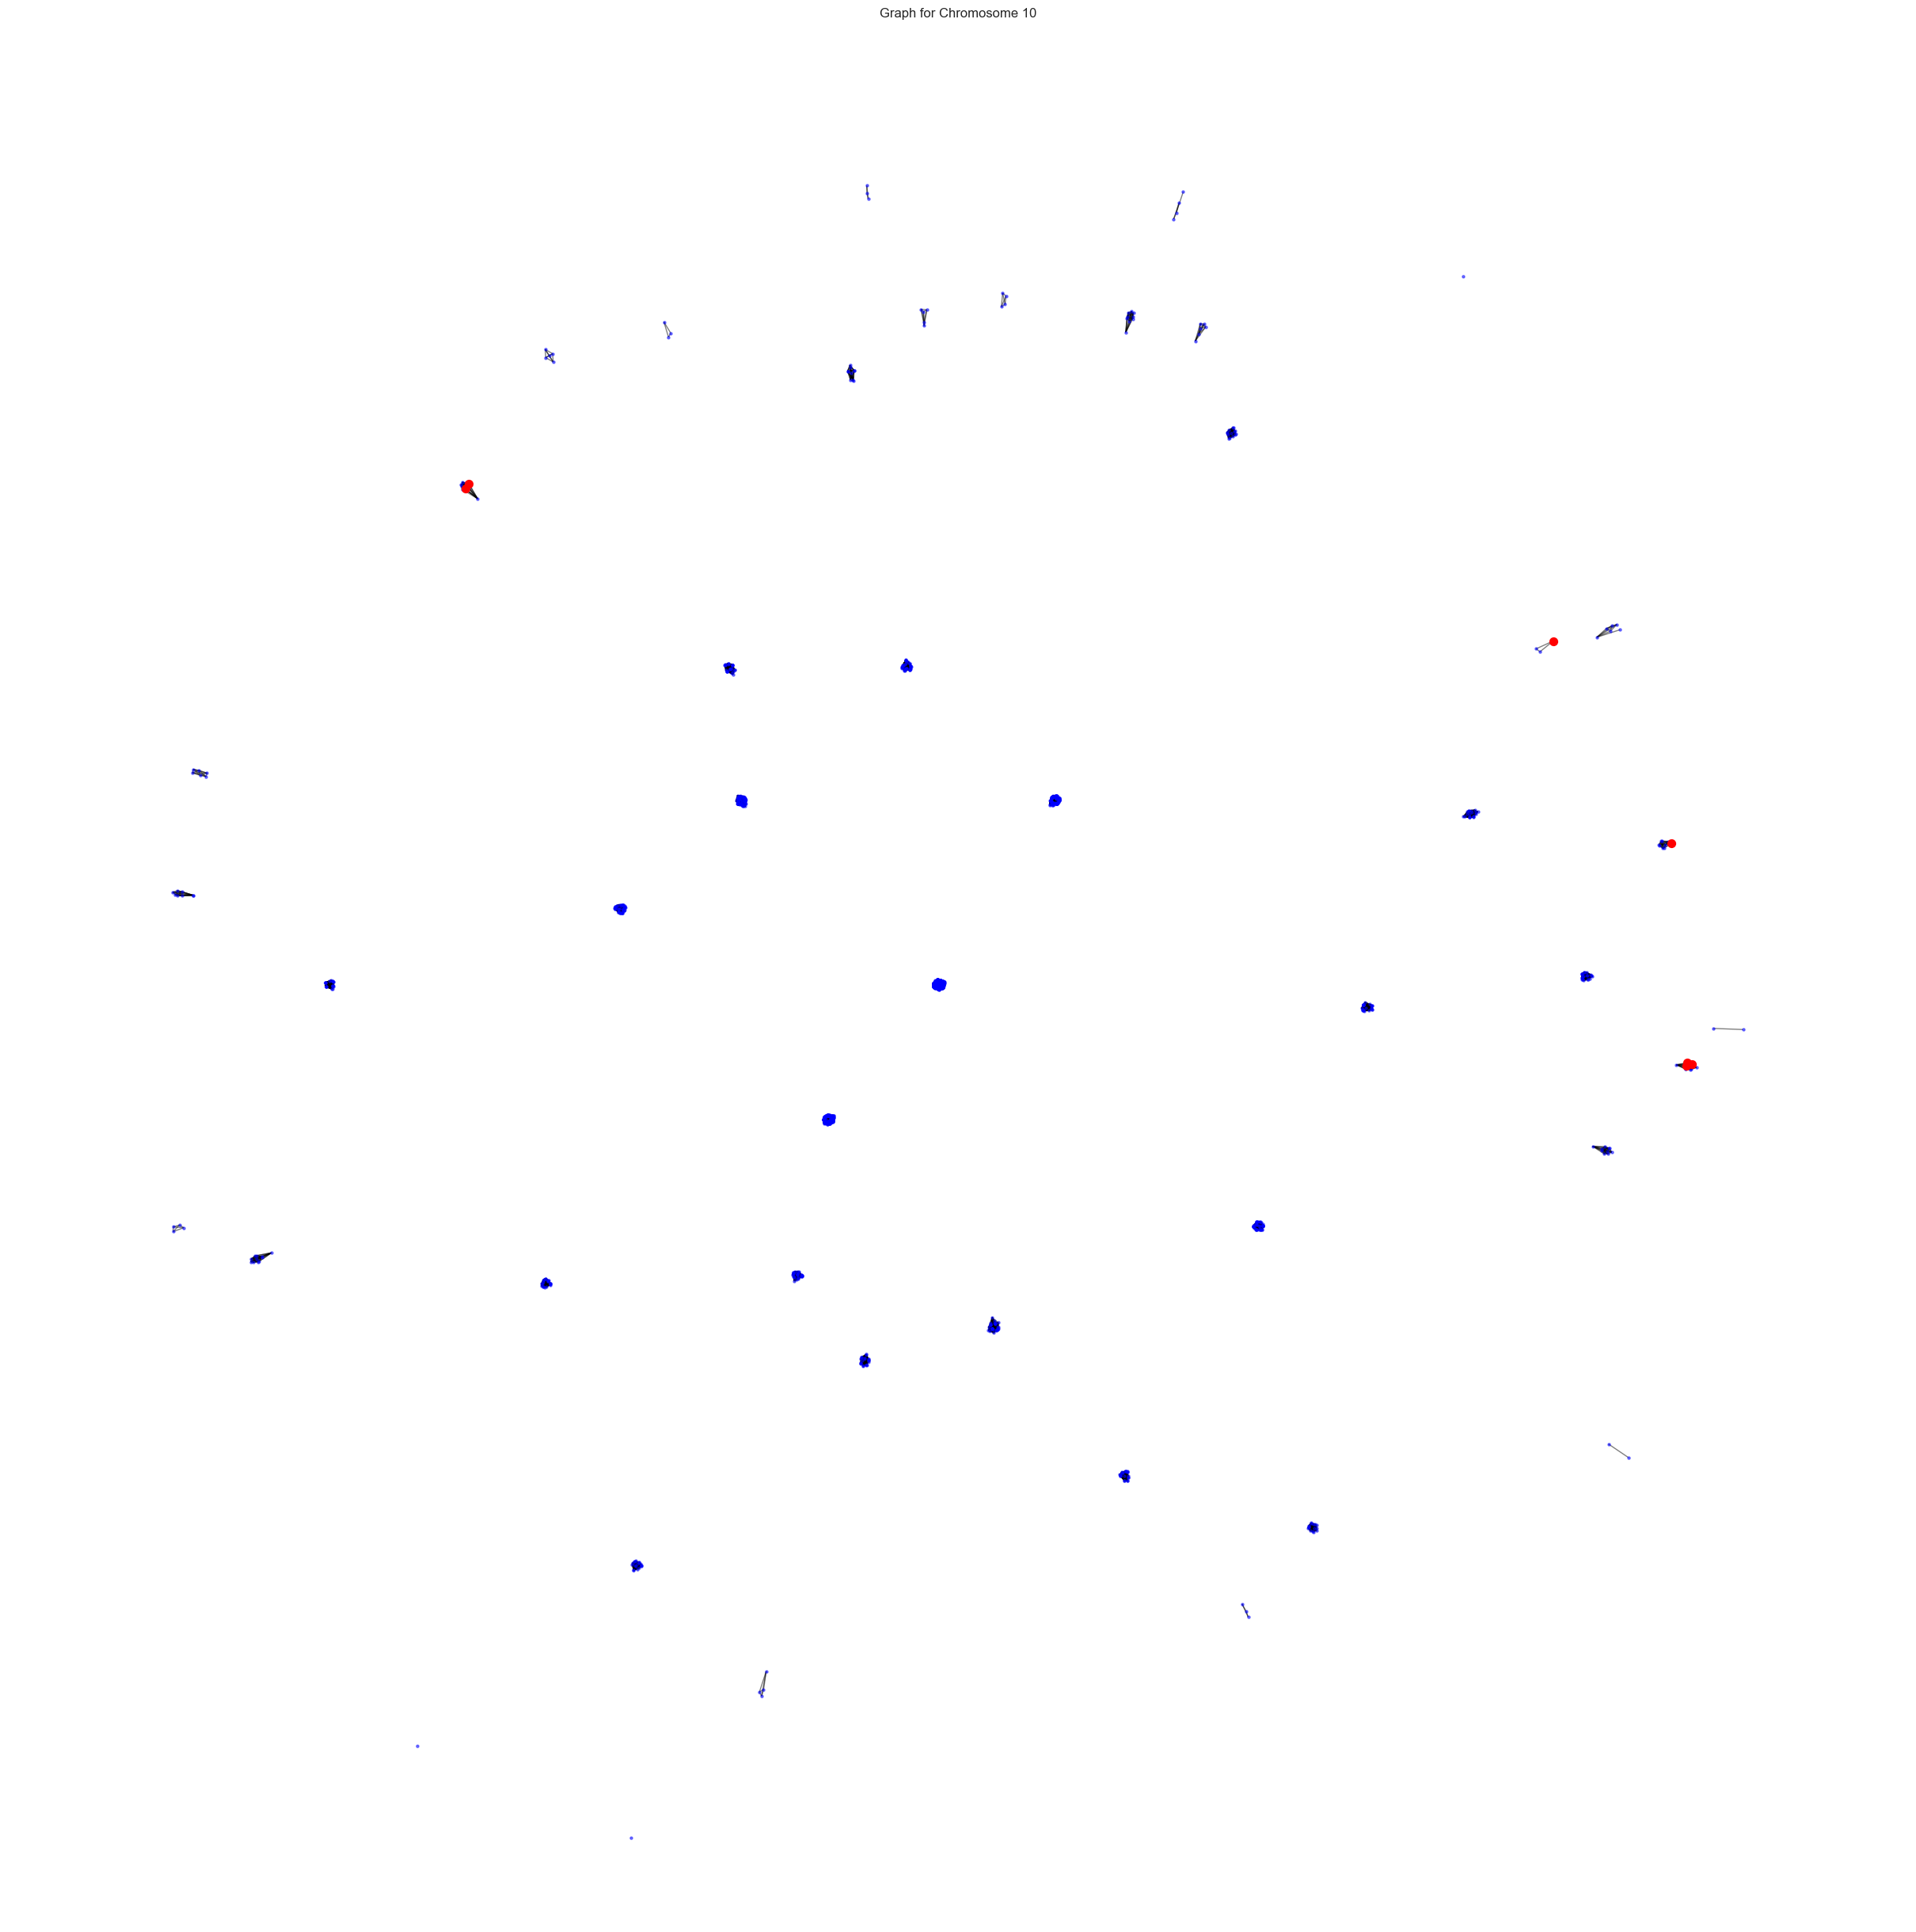

CPU times: total: 34.6 s
Wall time: 35.2 s


In [6]:
%%time

import pandas as pd
import networkit as nk
from itertools import combinations
from collections import defaultdict

# Load and prepare the data
data = pd.read_parquet('gwas_fm_t2d.parquet')

# Process only chromosome 10
chrom = 10

df = data[data['#chrom'] == chrom]
df.reset_index(drop=True, inplace=True)

# Initialize an empty list to store results
results = []

print(f"Processing chromosome {chrom}...")

# Create a graph and add nodes
G = nk.Graph(directed=False)
G.addNodes(len(df))

# Store node attributes in a dictionary
attributes = ['pos', 'ref', 'alt', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'prob', 'lead_r2', 'cs_99', 'causal']
node_attributes = {attr: df[attr].tolist() for attr in attributes}

# Get gene columns and create a mapping from gene values to node indices
gene_cols = [f'gene_{i}' for i in range(22)]
melted_df = df.reset_index().melt(id_vars='index', value_vars=gene_cols)
grouped_df = melted_df[melted_df['value'].notnull() & (melted_df['value'] != 0)].groupby('value')['index'].apply(list)

# Add edges to the graph based on genes
added_edges = set()
for node_indices in grouped_df:
    for i, j in combinations(node_indices, 2):
        if (i, j) not in added_edges and (j, i) not in added_edges:
            G.addEdge(i, j)
            added_edges.add((i, j))

# Compute the number of connected components
components = nk.components.ConnectedComponents(G)
components.run()

# Get the component of each node and identify causal nodes
node_to_component = components.getPartition()
causal_node_indices = [i for i, val in enumerate(node_attributes['causal']) if val == 1]

# Identify and print details of components with causal nodes
causal_node_components = {i: node_to_component[i] for i in causal_node_indices}

component_sizes = components.getComponentSizes()
unique_component_ids_and_sizes = {component: component_sizes[component] for component in set(causal_node_components.values())}

# Check for edges between causal nodes in the same component
components_to_causal_nodes = defaultdict(list)
for node, component in causal_node_components.items():
    components_to_causal_nodes[component].append(node)

# Create a dictionary to store results of the current chromosome
chrom_results = {
    "chromosome": chrom,
    "total_nodes": G.numberOfNodes(),
    "total_edges": G.numberOfEdges(),
    "connected_components": components.numberOfComponents(),
    "causal_nodes_count": len(causal_node_indices),
    "causal_node_details": causal_node_components,
    "component_details": unique_component_ids_and_sizes,
    "edge_checks": []
}

for component, nodes in components_to_causal_nodes.items():
    for u, v in combinations(nodes, 2):
        has_edge = G.hasEdge(u, v)
        edge_check_details = {
            "component": component, 
            "node_pair": (u, v), 
            "has_edge": has_edge
        }
        chrom_results["edge_checks"].append(edge_check_details)

# Add the current chromosome's results to the list
results.append(chrom_results)

# Convert the networkit graph to a networkx graph for visualization
G_nx = nk.nxadapter.nk2nx(G)

import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(24, 24))

# Using spring_layout for faster rendering; adjust as per need.
pos = nx.spring_layout(G_nx, iterations=50)  

# Extract nodes with causal=1
causal_nodes = [index for index, is_causal in enumerate(node_attributes['causal']) if is_causal == 1]

# Draw all nodes
nx.draw(G_nx, pos, node_size=5, node_color="blue", alpha=0.5, with_labels=False)

# Draw only causal=1 nodes on top with bright red color and larger size
nx.draw_networkx_nodes(G_nx, pos, nodelist=causal_nodes, node_color="red", node_size=50, alpha=1)

plt.title("Graph for Chromosome 10")
plt.show()


### Chrom 11

Processing chromosome 11...


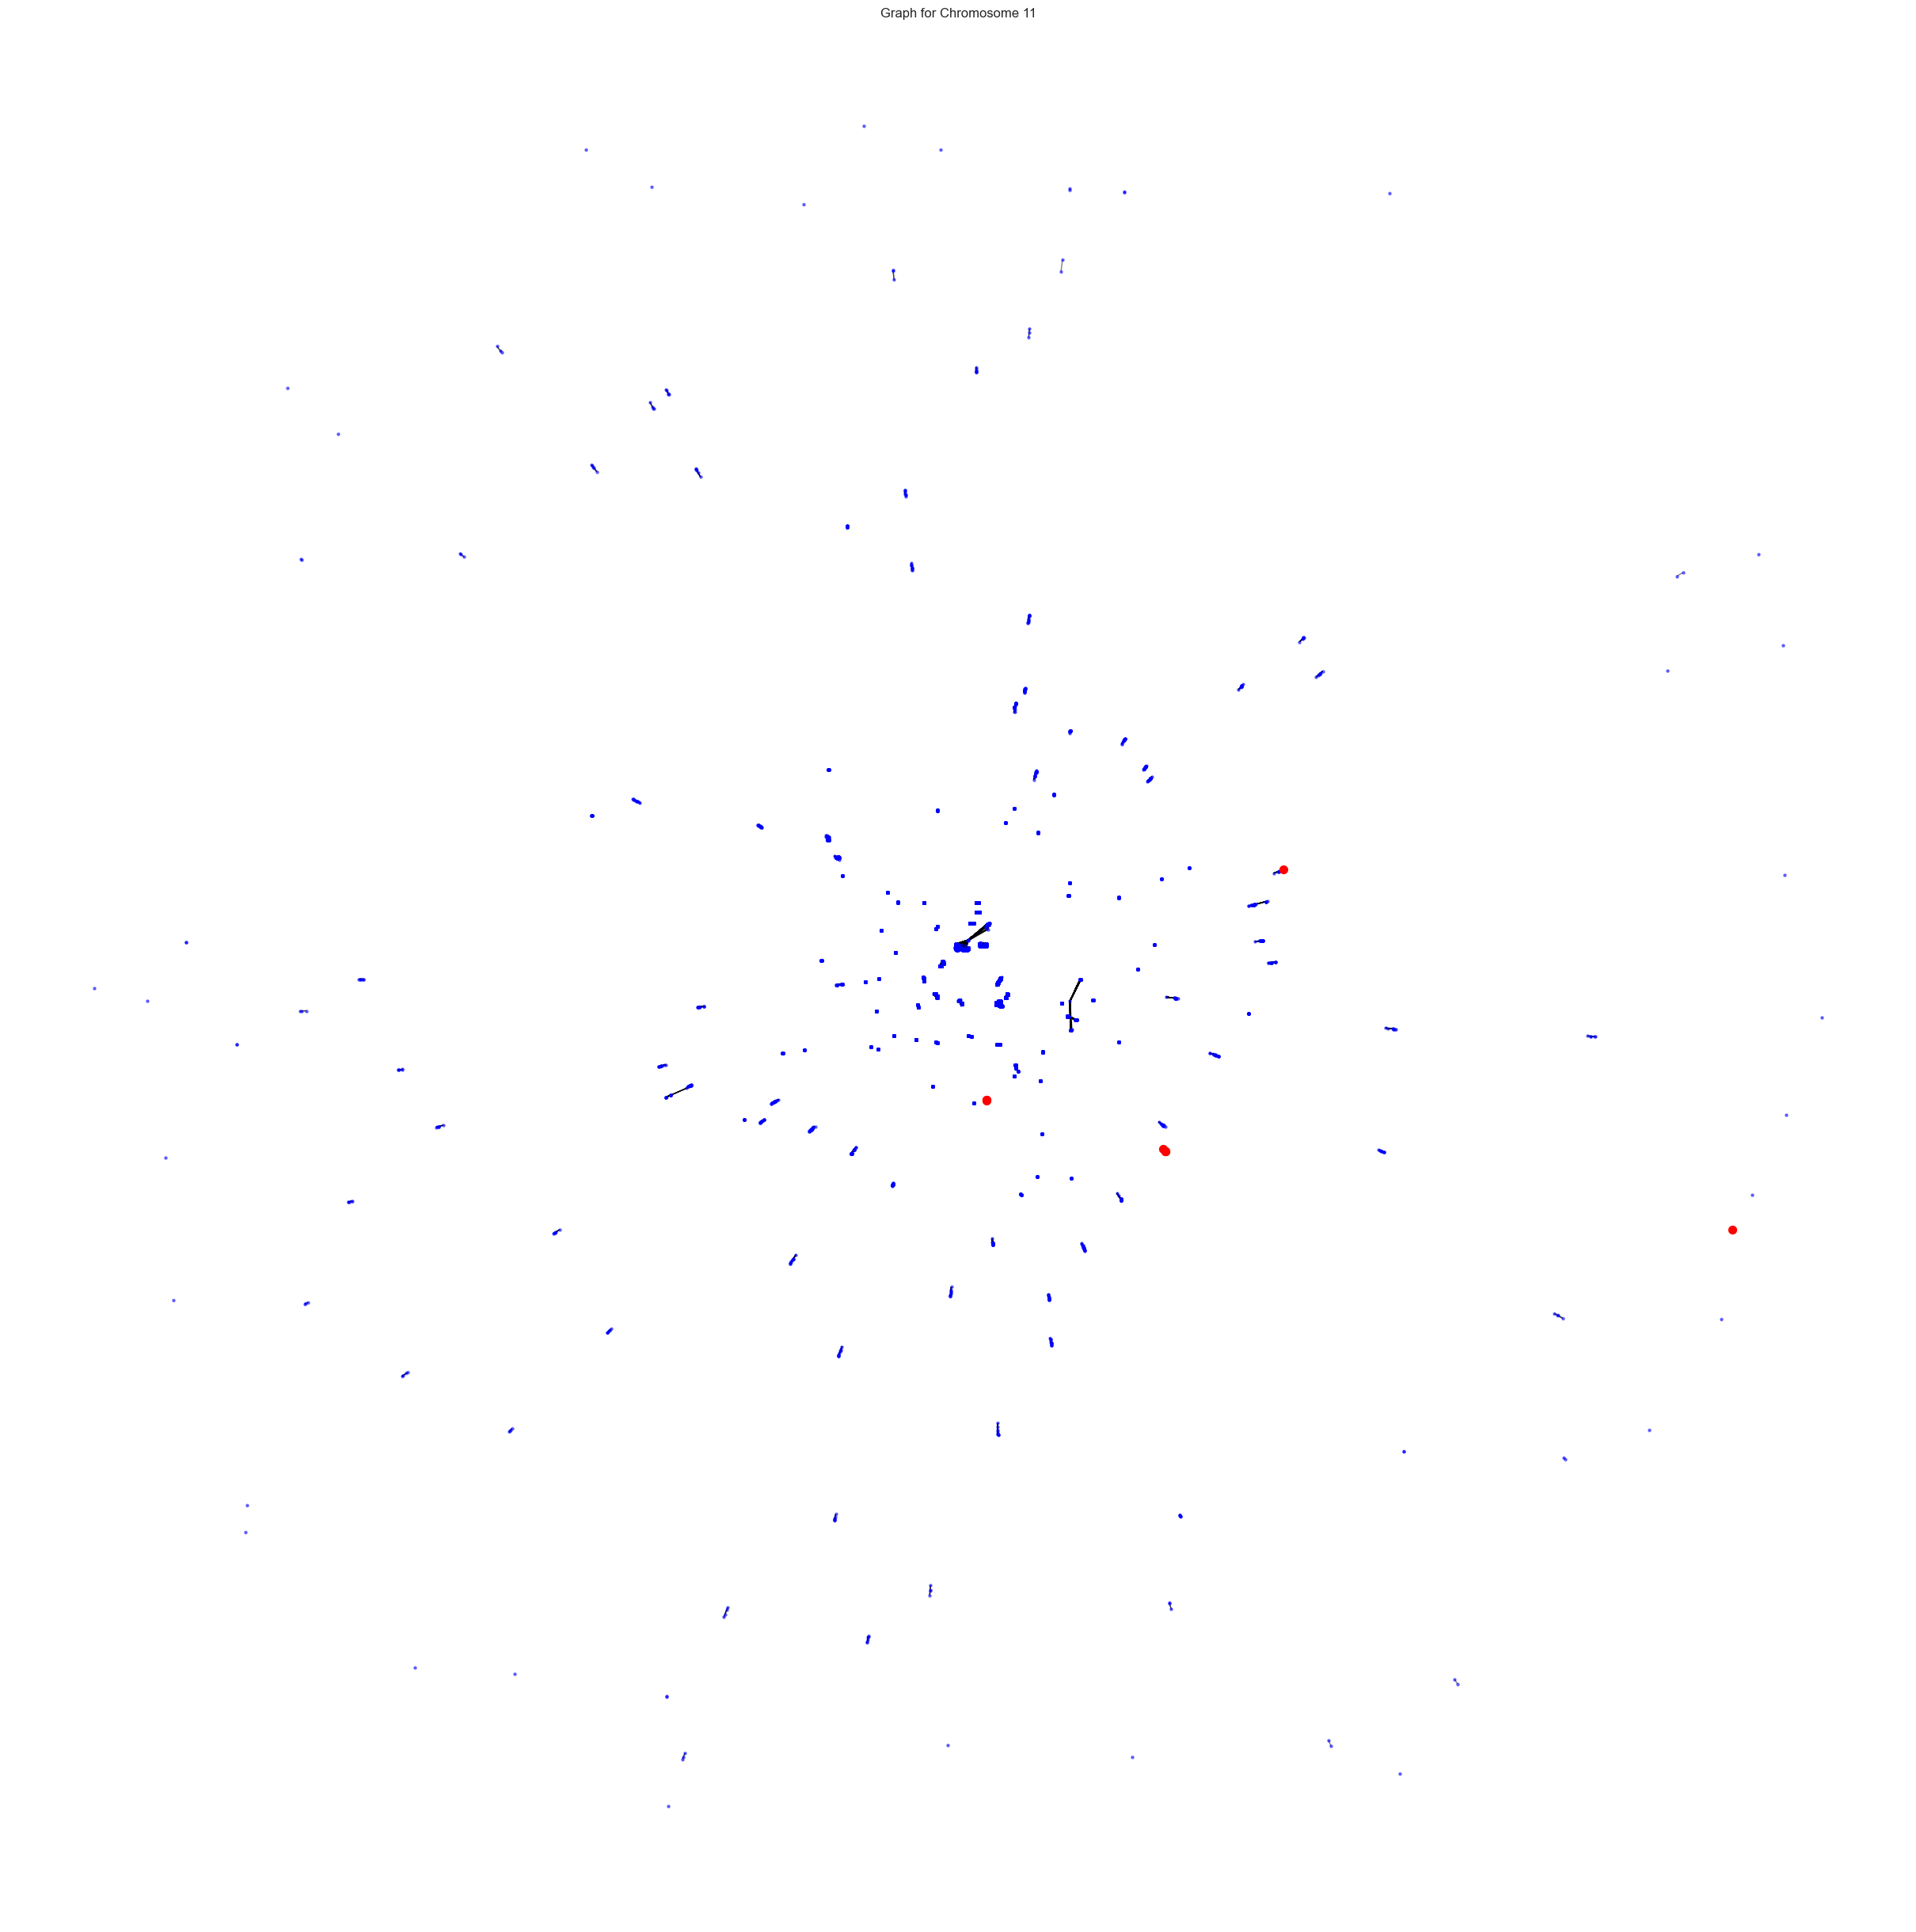

CPU times: total: 27min 25s
Wall time: 27min 47s


In [7]:
%%time

import pandas as pd
import networkit as nk
from itertools import combinations
from collections import defaultdict

# Load and prepare the data
data = pd.read_parquet('gwas_fm_t2d.parquet')

# Process only chromosome 11
chrom = 11

df = data[data['#chrom'] == chrom]
df.reset_index(drop=True, inplace=True)

# Initialize an empty list to store results
results = []

print(f"Processing chromosome {chrom}...")

# Create a graph and add nodes
G = nk.Graph(directed=False)
G.addNodes(len(df))

# Store node attributes in a dictionary
attributes = ['pos', 'ref', 'alt', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'prob', 'lead_r2', 'cs_99', 'causal']
node_attributes = {attr: df[attr].tolist() for attr in attributes}

# Get gene columns and create a mapping from gene values to node indices
gene_cols = [f'gene_{i}' for i in range(22)]
melted_df = df.reset_index().melt(id_vars='index', value_vars=gene_cols)
grouped_df = melted_df[melted_df['value'].notnull() & (melted_df['value'] != 0)].groupby('value')['index'].apply(list)

# Add edges to the graph based on genes
added_edges = set()
for node_indices in grouped_df:
    for i, j in combinations(node_indices, 2):
        if (i, j) not in added_edges and (j, i) not in added_edges:
            G.addEdge(i, j)
            added_edges.add((i, j))

# Compute the number of connected components
components = nk.components.ConnectedComponents(G)
components.run()

# Get the component of each node and identify causal nodes
node_to_component = components.getPartition()
causal_node_indices = [i for i, val in enumerate(node_attributes['causal']) if val == 1]

# Identify and print details of components with causal nodes
causal_node_components = {i: node_to_component[i] for i in causal_node_indices}

component_sizes = components.getComponentSizes()
unique_component_ids_and_sizes = {component: component_sizes[component] for component in set(causal_node_components.values())}

# Check for edges between causal nodes in the same component
components_to_causal_nodes = defaultdict(list)
for node, component in causal_node_components.items():
    components_to_causal_nodes[component].append(node)

# Create a dictionary to store results of the current chromosome
chrom_results = {
    "chromosome": chrom,
    "total_nodes": G.numberOfNodes(),
    "total_edges": G.numberOfEdges(),
    "connected_components": components.numberOfComponents(),
    "causal_nodes_count": len(causal_node_indices),
    "causal_node_details": causal_node_components,
    "component_details": unique_component_ids_and_sizes,
    "edge_checks": []
}

for component, nodes in components_to_causal_nodes.items():
    for u, v in combinations(nodes, 2):
        has_edge = G.hasEdge(u, v)
        edge_check_details = {
            "component": component, 
            "node_pair": (u, v), 
            "has_edge": has_edge
        }
        chrom_results["edge_checks"].append(edge_check_details)

# Add the current chromosome's results to the list
results.append(chrom_results)

# Convert the networkit graph to a networkx graph for visualization
G_nx = nk.nxadapter.nk2nx(G)

import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(24, 24))

# Using spring_layout for faster rendering; adjust as per need.
pos = nx.spring_layout(G_nx, iterations=50)  

# Extract nodes with causal=1
causal_nodes = [index for index, is_causal in enumerate(node_attributes['causal']) if is_causal == 1]

# Draw all nodes
nx.draw(G_nx, pos, node_size=5, node_color="blue", alpha=0.5, with_labels=False)

# Draw only causal=1 nodes on top with bright red color and larger size
nx.draw_networkx_nodes(G_nx, pos, nodelist=causal_nodes, node_color="red", node_size=50, alpha=1)

plt.title("Graph for Chromosome 11")
plt.show()
